<a href="https://colab.research.google.com/github/torifinch/AB_Testing/blob/main/ABTesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📈 A/B Testing Analysis: Marketing Campaign Performance

**Author:** Victoria Finch  
**Role:** Data Analyst  
**Tools Used:** Python, Pandas, Seaborn, SciPy  
**Dataset:** Simulated marketing campaigns (Control vs Test)

---

##  Project Summary

This project investigates whether a new marketing campaign strategy leads to improved performance over a previous campaign. Using A/B testing principles, we compare:

- **Return on Investment (ROI)**  
- **Purchase Rate (PR)**  

We perform statistical testing (Mann-Whitney U Test) to determine whether observed differences are statistically significant, and we draw actionable insights for business decision-making.

---

##  Hypotheses

1. **H1**: The *Test Campaign* results in a **5%+ increase in ROI** compared to the *Control Campaign*.
2. **H2**: The *Test Campaign* results in an **8%+ increase in Purchase Rate (PR)** compared to the *Control Campaign*.

---

##  Notebook Contents

- Data Cleaning & Feature Engineering
- Exploratory Data Analysis (EDA)
- Hypothesis Testing (Non-Parametric)
- Visualizations of Results
- Final Insights & Recommendations


###IMPORT LIBRARIES & DATA

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from scipy.stats import mannwhitneyu, ttest_ind, levene, shapiro
#hypothesis testing
from statsmodels.stats.proportion import proportions_ztest

In [55]:
# Connect drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
df_test = pd.read_csv('/content/drive/MyDrive/Datasets/AB_Marketing/test_group.csv', delimiter=';')
df_control = pd.read_csv('/content/drive/MyDrive/Datasets/AB_Marketing/control_group.csv', delimiter=';')

df_full = pd.concat([df_test, df_control])
df_full.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Test Campaign,1.08.2019,3008,39550.0,35820.0,3038.0,1946.0,1069.0,894.0,255.0
1,Test Campaign,2.08.2019,2542,100719.0,91236.0,4657.0,2359.0,1548.0,879.0,677.0
2,Test Campaign,3.08.2019,2365,70263.0,45198.0,7885.0,2572.0,2367.0,1268.0,578.0
3,Test Campaign,4.08.2019,2710,78451.0,25937.0,4216.0,2216.0,1437.0,566.0,340.0
4,Test Campaign,5.08.2019,2297,114295.0,95138.0,5863.0,2106.0,858.0,956.0,768.0


###DATA PREPARATION AND CLEANING

In [57]:
# Check datatypes
df_full.dtypes

,0
Campaign Name,object
Date,object
Spend [USD],int64
# of Impressions,float64
Reach,float64
# of Website Clicks,float64
# of Searches,float64
# of View Content,float64
# of Add to Cart,float64
# of Purchase,float64


In [58]:
# Update Datetime Format
df_full['Date'] = pd.to_datetime(df_full['Date'], format='%d.%m.%Y')

In [59]:
#Remove Spaces from Columns
df_full.columns = df_full.columns.str.replace(' ', '_')

#All lowercase
df_full.columns = df_full.columns.str.lower()

In [60]:
# Unique campaign name
df_full['campaign_name'].unique()

array(['Test Campaign', 'Control Campaign'], dtype=object)

In [61]:
df_full.head()

,campaign_name,date,spend_[usd],#_of_impressions,reach,#_of_website_clicks,#_of_searches,#_of_view_content,#_of_add_to_cart,#_of_purchase
0,Test Campaign,2019-08-01,3008,39550.0,35820.0,3038.0,1946.0,1069.0,894.0,255.0
1,Test Campaign,2019-08-02,2542,100719.0,91236.0,4657.0,2359.0,1548.0,879.0,677.0
2,Test Campaign,2019-08-03,2365,70263.0,45198.0,7885.0,2572.0,2367.0,1268.0,578.0
3,Test Campaign,2019-08-04,2710,78451.0,25937.0,4216.0,2216.0,1437.0,566.0,340.0
4,Test Campaign,2019-08-05,2297,114295.0,95138.0,5863.0,2106.0,858.0,956.0,768.0


###CHECK NULLS

In [62]:
#Check for nan values
df_full.isna().sum()

,0
campaign_name,0
date,0
spend_[usd],0
#_of_impressions,1
reach,1
#_of_website_clicks,1
#_of_searches,1
#_of_view_content,1
#_of_add_to_cart,1
#_of_purchase,1


In [63]:
#Check null values
df_full[df_full.isna().any(axis=1)]

,campaign_name,date,spend_[usd],#_of_impressions,reach,#_of_website_clicks,#_of_searches,#_of_view_content,#_of_add_to_cart,#_of_purchase
4,Control Campaign,2019-08-05,1835,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Becasue all of the null values are in one campaign, it makes the data unusable. I will drop it.

In [64]:
# Drop nulls
df_full = df_full.dropna()

###FEATURE CREATION

In [ ]:
# Return on Investment
df_full['ROI'] = df_full['spend_[usd]']/df_full['#_of_purchase']
# Click through rate
df_full['CTR'] = df_full['#_of_website_clicks']/df_full['#_of_impressions']
# Purchase Rate
df_full['PR'] = df_full['#_of_purchase']/df_full['#_of_impressions']


###EDA & VISUALIZATIONS

Making sure the campaigns are even

In [80]:
# Number of campaigns by name
df_full['campaign_name'].value_counts()

,count
campaign_name,
Test Campaign,30
Control Campaign,29


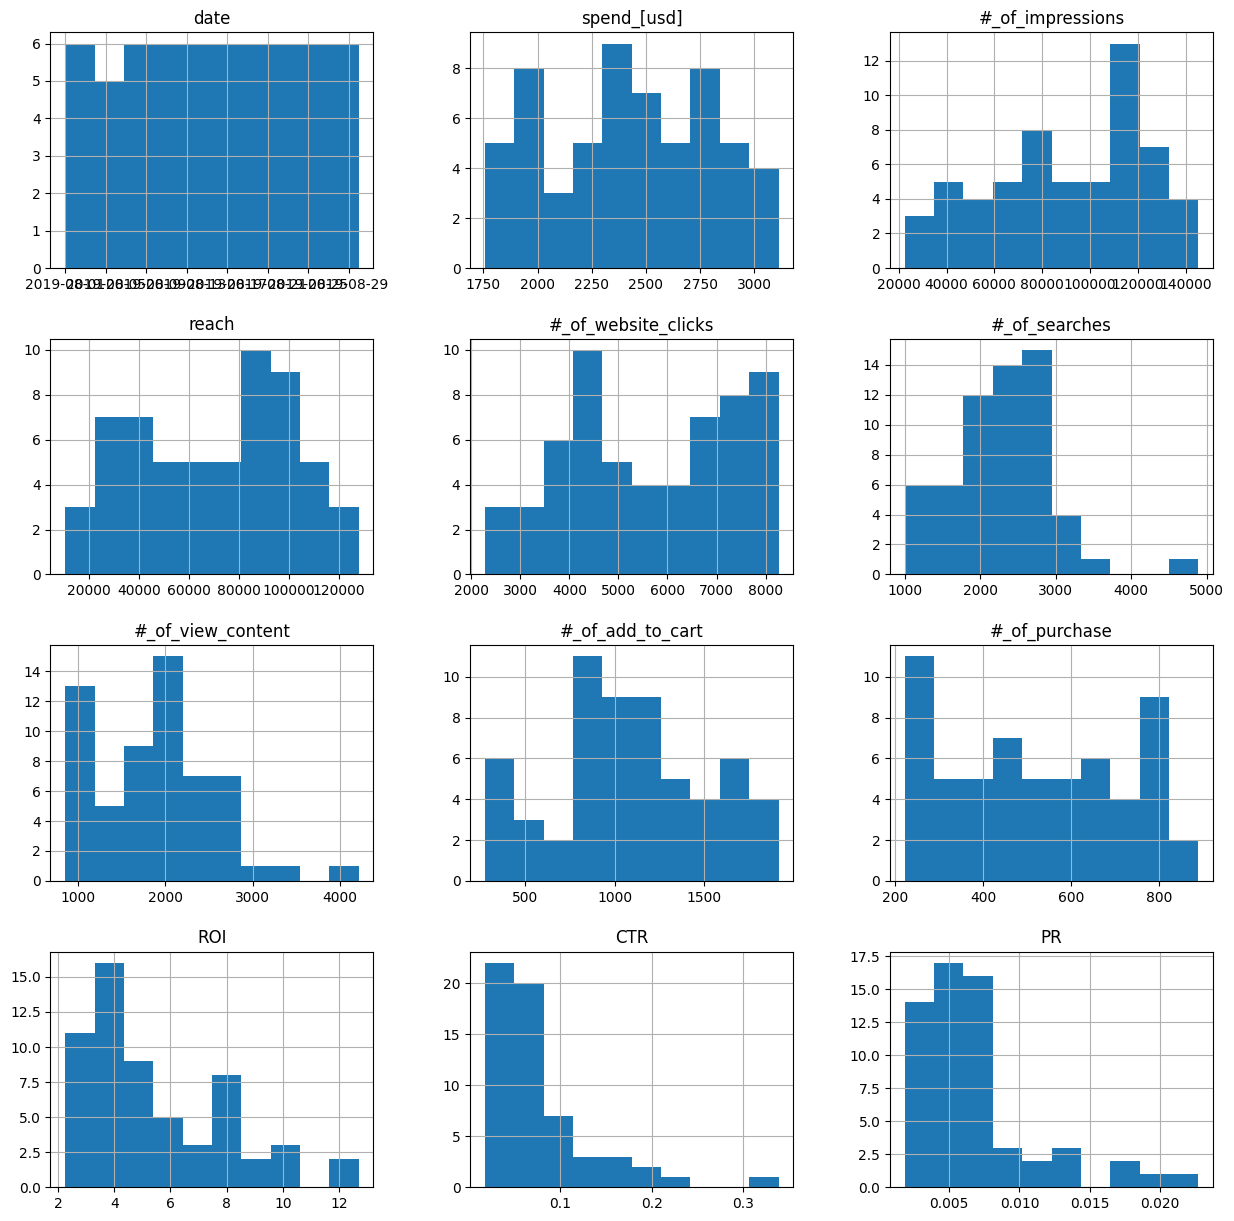

In [81]:
# Hist
df_full.hist(figsize=(15,15))
plt.show()

Let's compare the two campaigns

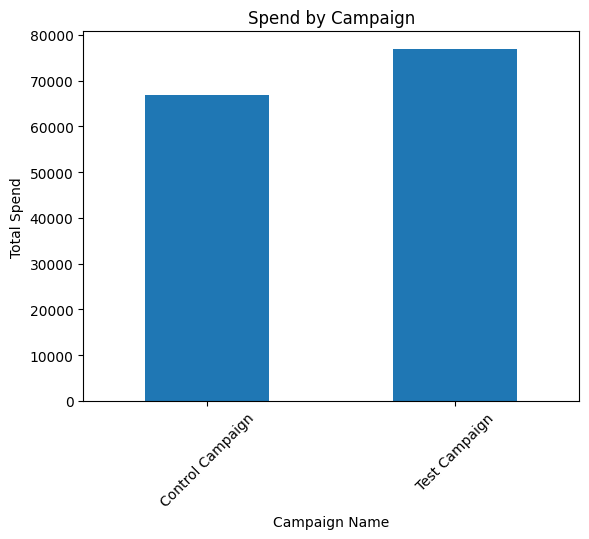

In [65]:
# Viz spend_[usd] by campaign_name
df_full.groupby('campaign_name')['spend_[usd]'].sum().plot(kind='bar')
plt.title('Spend by Campaign')
plt.xlabel('Campaign Name')
plt.xticks(rotation=45)
plt.ylabel('Total Spend')
plt.show()

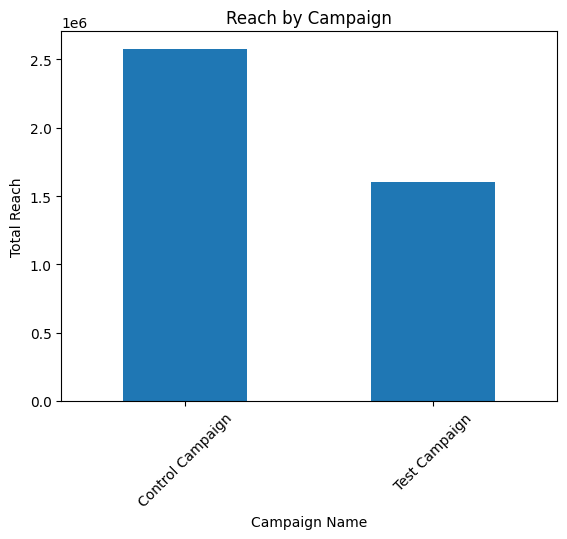

In [66]:
# Viz reach by campaign_name
df_full.groupby('campaign_name')['reach'].sum().plot(kind='bar')
plt.title('Reach by Campaign')
plt.xlabel('Campaign Name')
plt.xticks(rotation=45)
plt.ylabel('Total Reach')
plt.show()

We're already seeing that despite the higher spend, the reach on the Test Campaign is much less than the Control Campaign.

Let's check what portion of the total spent went to each campaign.

In [67]:
# spend_[usd] by campaign_name by percent
df_full.groupby('campaign_name')['spend_[usd]'].sum()/df_full['spend_[usd]'].sum().sum()*100

,spend_[usd]
campaign_name,
Control Campaign,46.495025
Test Campaign,53.504975


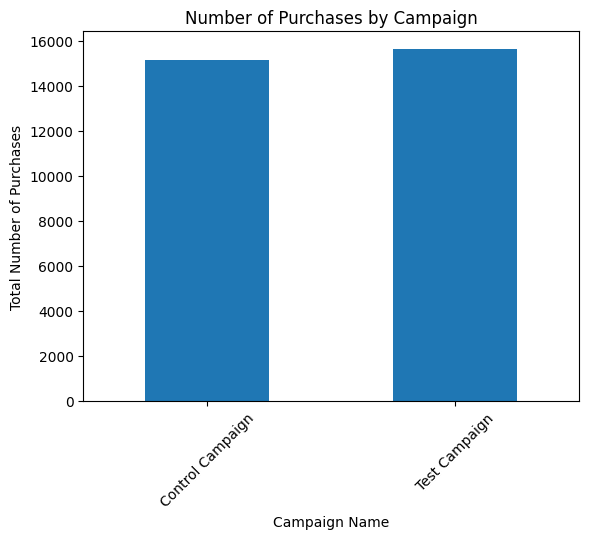

In [71]:
# Viz Number of purchases by campaign
df_full.groupby('campaign_name')['#_of_purchase'].sum().plot(kind='bar')
plt.title('Number of Purchases by Campaign')
plt.xlabel('Campaign Name')
plt.xticks(rotation=45)
plt.ylabel('Total Number of Purchases')
plt.show()

In [108]:
# purchases by campaign
df_full.groupby('campaign_name')['#_of_purchase'].sum()

,#_of_purchase
campaign_name,
Control Campaign,15161.0
Test Campaign,15637.0


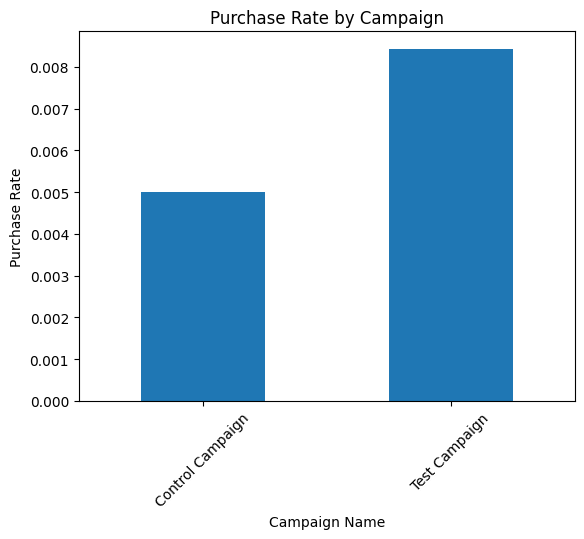

In [110]:
# Viz PR by Campaign
df_full.groupby('campaign_name')['PR'].mean().plot(kind='bar')
plt.title('Purchase Rate by Campaign')
plt.xlabel('Campaign Name')
plt.xticks(rotation=45)
plt.ylabel('Purchase Rate')
plt.show()

Here is where the Test Campaign is shining, though the reach was lower it ended up outselling the Control Campaign!

Lets check the ROI feature I created

In [74]:
# ROI
df_full.groupby('campaign_name')['ROI'].mean()

,ROI
campaign_name,
Control Campaign,5.052339
Test Campaign,5.899589


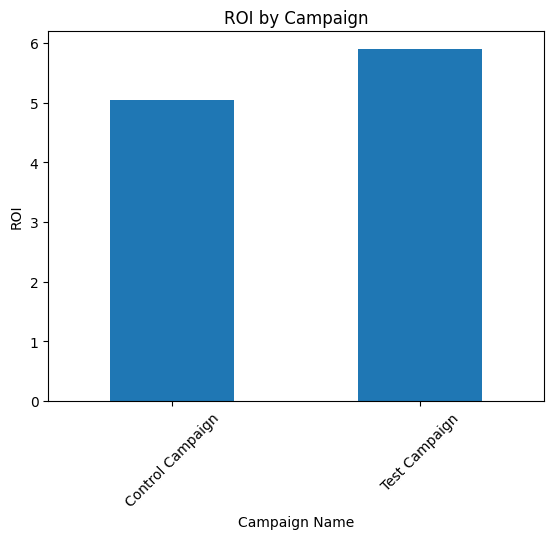

In [111]:
# ROI Viz
df_full.groupby('campaign_name')['ROI'].mean().plot(kind='bar')
plt.title('ROI by Campaign')
plt.xlabel('Campaign Name')
plt.xticks(rotation=45)
plt.ylabel('ROI')
plt.show()

##TESTING THE HYPOTHESIS

Check normality (Shapiro-Wilk test) for ROI and PR

In [91]:
from scipy.stats import shapiro

ROItest = shapiro(df_full['ROI'])


PRtest = shapiro(df_full['PR'])

print(f'Test for ROI: {ROItest}')
print(f'Test for PR: {PRtest}')
if ROItest.pvalue < 0.05:
    print('Reject the null hypothesis of ROI normality')
else:
    print('Fail to reject the null hypothesis of ROI normality')

if PRtest.pvalue < 0.05:
    print('Reject the null hypothesis of PR normality')
else:
    print('Fail to reject the null hypothesis of PR normality')

Test for ROI: ShapiroResult(statistic=np.float64(0.9030853524200269), pvalue=np.float64(0.0001932086735502074))
Test for PR: ShapiroResult(statistic=np.float64(0.829569751755573), pvalue=np.float64(9.454052763091549e-07))
Reject the null hypothesis of ROI normality
Reject the null hypothesis of PR normality


1. ROI
W = 0.903

p-value = 0.00019

Interpretation: p < 0.05 → Reject the null hypothesis of normality → ROI is not normally distributed

2. PR
W = 0.829

p-value ≈ 0.000000945

Interpretation: p < 0.05 → PR is also not normally distributed

Since both ROI and PR are not normally distributed, I should use non-parametric tests instead of the t-test.

Mann-Whitney U Test

In [94]:
#Mann-Whitney U Test
mannwhitneyu_test = mannwhitneyu(df_full[df_full['campaign_name'] == 'Control Campaign']['ROI'], df_full[df_full['campaign_name'] == 'Test Campaign']['ROI'])
print(f'Mann-Whitney U Test: {mannwhitneyu_test}')
if mannwhitneyu_test.pvalue < 0.05:
    print('ROI: Reject the null hypothesis of equal distributions')
    print('There is a significant difference in the ROI distributions of the two groups')
else:
    print('ROI Fail to reject the null hypothesis of equal distributions')
    print('There is no significant difference in the ROI distributions of the two groups')

Mann-Whitney U Test: MannwhitneyuResult(statistic=np.float64(362.0), pvalue=np.float64(0.27166245232517694))
ROI Fail to reject the null hypothesis of equal distributions
There is no significant difference in the ROI distributions of the two groups


In [95]:
#Mann-Whitney U Test
mannwhitneyu_test = mannwhitneyu(df_full[df_full['campaign_name'] == 'Control Campaign']['PR'], df_full[df_full['campaign_name'] == 'Test Campaign']['PR'])
print(f'Mann-Whitney U Test: {mannwhitneyu_test}')
if mannwhitneyu_test.pvalue < 0.05:
    print('PR: Reject the null hypothesis of equal distributions')
    print('There is a significant difference in the PR distributions of the two groups')
else:
    print('PR: Fail to reject the null hypothesis of equal distributions')
    print('There is no significant difference in the PR distributions of the two groups')

Mann-Whitney U Test: MannwhitneyuResult(statistic=np.float64(245.0), pvalue=np.float64(0.00406347614003368))
PR: Reject the null hypothesis of equal distributions
There is a significant difference in the PR distributions of the two groups


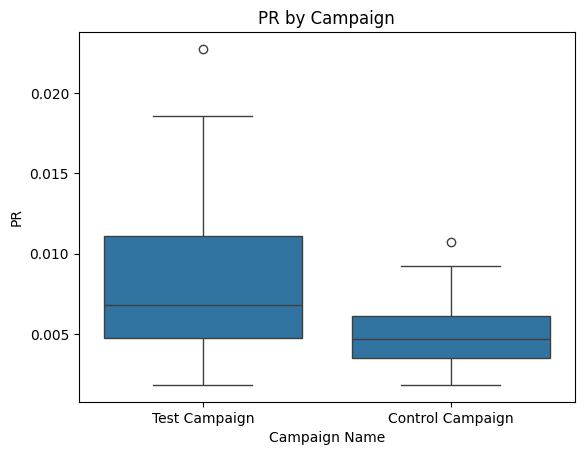

In [112]:
# PR boxplot
sns.boxplot(x='campaign_name', y='PR', data=df_full)
plt.title('PR by Campaign')
plt.xlabel('Campaign Name')
plt.ylabel('PR')
plt.show()

###Results:
1. There is not enough statistical evidence to say the test campaign’s ROI is significantly higher than the control campaign’s.

2. The Test Campaign performed better in terms of Purchase Rate — your hypothesis is supported!

While ROI didn’t pass the significance test, PR did. So even if the test campaigns didn’t earn more money per dollar spent, they were more effective at converting impressions into purchases.

###Meaning:
Even if ROI gains weren’t statistically significant, the campaigns showed a meaningful and significant improvement in the purchase rate, signaling stronger audience engagement or better messaging.

Let's look more into the ROI that failed:

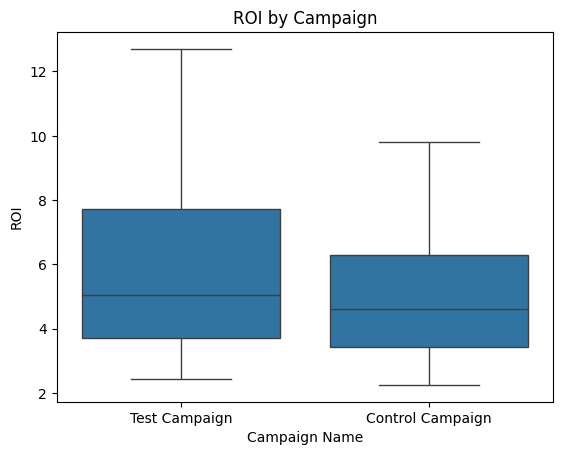

In [96]:

sns.boxplot(x='campaign_name', y='ROI', data=df_full)
plt.title('ROI by Campaign')
plt.xlabel('Campaign Name')
plt.ylabel('ROI')
plt.show()


In [97]:
# Check Median ROI
print(df_full.groupby('campaign_name')['ROI'].median())

campaign_name
Control Campaign    4.621005
Test Campaign       5.062840
Name: ROI, dtype: float64


In [107]:
roi_lift = (5.06 - 4.62) / 4.62 * 100
lift_rounded = round(roi_lift, 2)
print(f'ROI Lift: {lift_rounded}%')

ROI Lift: 9.52%


The Test Campaign saw an approximate 9.5% increase in mean ROI compared to the Control Campaign.

### Statistics Breakdown
***Why Was a 9.5% ROI Lift Not Statistically Significant If the Hypothesis Was Only for 5%?***

Because statistical significance isn't just about the size of the effect — it's about how confidently we can say the observed effect wasn’t due to random chance.

A 9.5% difference is great, but the p-value (0.27) told us:

“There’s a 27% chance that this difference could have happened randomly, assuming there’s no real difference at all.”

That’s way above the 5% (p = 0.05) threshold most analysts use.

# Results Overview:

ROI (Return on Investment):

Mean ROI increased from 4.62 to 5.06 (~9.5% lift)

However, this difference was not statistically significant based on the Mann-Whitney U test (p = 0.2717)

**Interpretation: We cannot confidently attribute the improvement to the test campaign rather than chance.**

PR (Purchase Rate):

Statistically significant improvement (p = 0.0041)

**Supports the hypothesis that the Test Campaign increased conversions**

###Recommendation:
Consider iterating or scaling the Test Campaign — especially if the objective is to drive more purchases, not necessarily maximize ROI in the short term. Continue monitoring ROI in future campaigns to see if this lift becomes significant with a larger sample.